## Timeseries IV Simulation

In [1]:
import os
import sys
sys.path.append('..')
IV_path = os.path.join('..', 'pvops', 'iv')
sys.path.append(IV_path)

from pvops.iv import simulator

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [3]:
import ast

def read_line(x):
    return np.array(ast.literal_eval(x))

example_prodpath = os.path.join('example_data', 'TMY_Seattle.csv')
env_df = pd.read_csv(example_prodpath, header=1)
env_df['datetime'] = (pd.to_datetime(env_df['Date (MM/DD/YYYY)'], format='%m/%d/%Y') + 
                  pd.to_timedelta(env_df['Time (HH:MM)'] + ':00'))
env_df.index = pd.to_datetime(env_df['datetime'])
env_df = env_df.sort_index()

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import math

class IVTimeseriesGenerator(simulator.Simulator):

    def __init__(self, **iv_sim_kwargs):
        """Simulate a PV System across time.

        Parameters
        ----------
        iv_sim_kwargs :
            Optional, `simulator.Simulator` inputs
        """
        super().__init__(**iv_sim_kwargs)

    def generate(self, env_df, failures, iv_col_dict, identifier_col, plot_trends=False):
        """Simulate a PV system

        Parameters
        ----------
        env_df : dataframe
            DataFrame containing irradiance ("E") and temperature ("T") columns
        failures : list
            List of timeseries_simulator.TimeseriesFailure objects

        Static modcell wrappings. TODO: make this dynamic
        """
        
        specs_df = env_df[[iv_col_dict["irradiance"],iv_col_dict["temperature"]]].copy()
        for failure in failures:
            # Weigh all failure definitions together
            specs_df = failure.add_interpolation(specs_df, plot_trends)

        condition_dicts = self._structure_Simulator_inputs(specs_df, iv_col_dict, identifier_col)

        return specs_df

    def _structure_Simulator_inputs(self, specs_df, iv_col_dict, identifier_col):
        keys = []
        savekeys = []
        spec_df_cols = specs_df.columns
        for key in ['identifier']+failures.acceptible_keys:
            if key == 'identifier':
                savekey = identifier_col
            elif key == 'E':
                savekey = iv_col_dict['irradiance']
            elif key == 'Tc':
                savekey = iv_col_dict['temperature']
            else:
                savekey = key
            if savekey in spec_df_cols:
                keys.append(key)
                savekeys.append(savekey)

        return [dict(zip(keys, l)) for l in specs_df[savekeys].values]

class TimeseriesFailure:
    def __init__(self):
        """Define a failure in terms of the affected diode
        parameters and specify how the failure evolves over
        time (i.e. how quickly does it itensify? how fast is
        it detected? how fast is it fixed?)
        """
        self.longterm_fcn_dict = {}
        self.annual_fcn_dict = {}
        self.daily_fcn_dict = {}
    
    def trend(self, longterm_fcn_dict=None, annual_fcn_dict=None, daily_fcn_dict=None, **kwargs):
        """Define a failure's trend across intraday (trending
        with time of day) and longterm timeframes.

        Parameters
        ----------
        longterm_fcn_dict : dict
            A dictionary where keys are the diode-multipliers in IVSimulator
            ('Rsh_mult', 'Rs_mult', 'Io_mult', 'Il_mult', 'nnsvth_mult') and
            values are either a function or a string. If a function, the
            function should be a mathematical operation as a `function of the
            number of float years since operation start`, a value on domain
            [0,inf), and outputs the chosen diode-multiplier's values across
            this timeseries. If a string, must use a pre-defined definition:

            * 'degrade' : degrade over time at specified rate. 
              Specify rate by passing a definition for 
              `degradation_rate` 

            For example,

            .. code-block:: python

                # 2 Ways of Doing Same Thing

                # Method 1
                longterm_fcn_dict = {
                    'Rs_mult': lambda x : 1.005 * x
                }
                f = Failure()
                f.trend(longterm_fcn_dict)

                # Method 2
                longterm_fcn_dict = {
                    'Rs_mult': 'degrade'
                }
                f = Failure()
                f.trend(longterm_fcn_dict,
                        degradation_rate=1.005)

        annual_fcn_dict : dict
            A dictionary where keys are the diode-multipliers in IVSimulator
            ('Rsh_mult', 'Rs_mult', 'Io_mult', 'Il_mult', 'nnsvth_mult') and
            values are either a function or a string. If a function, the
            function should be a mathematical operation as a `function of the
            percentage through this year`, a value on domain [0,1], and outputs
            the chosen diode-multiplier's values across this timeseries. If a 
            string, must use a pre-defined definition:

        daily_fcn_dict : function or str
            A dictionary where keys are the diode-multipliers in IVSimulator
            ('Rsh_mult', 'Rs_mult', 'Io_mult', 'Il_mult', 'nnsvth_mult') and
            values are either a function or a string. If a function, the
            function should be a mathematical operation as a `function of the
            percentage through this day`, a value on domain [0,1], and outputs
            the chosen diode-multiplier's values across this timeseries. If a 
            string, must use a pre-defined definition:
        """

        if not isinstance(longterm_fcn_dict, type(None)):
            self.longterm_fcn_dict = longterm_fcn_dict

            for param, fcn in longterm_fcn_dict.items():
                if isinstance(fcn,str):
                    self._predefined_trend(param, longterm_fcn=fcn, **kwargs)

        if not isinstance(annual_fcn_dict, type(None)):
            self.annual_fcn_dict = annual_fcn_dict

            for param, fcn in annual_fcn_dict.items():
                if isinstance(fcn,str):
                    self._predefined_trend(param, annual_fcn=fcn, **kwargs)

        if not isinstance(daily_fcn_dict, type(None)):
            self.daily_fcn_dict = daily_fcn_dict

            for param, fcn in daily_fcn_dict.items():
                if isinstance(fcn,str):
                    self._predefined_trend(param, daily_fcn=fcn, **kwargs)


    def _predefined_trend(self, param, longterm_fcn='degrade', annual_fcn='', daily_fcn='uniform', **kwargs):

        if longterm_fcn == 'degrade':
            try:
                degr_rate = kwargs['degradation_rate']
            except KeyError:
                raise KeyError("TimeseriesFailure.trend requires a passed parameter `degradation_rate`"
                               "if using `degrade` longterm_fcn definition.")
            self.longterm_fcn_dict[param] = lambda x : degr_rate * x

    def _combine(self, arr, specs_df, param):
        if param not in specs_df.columns:
            specs_df[param] = np.ones(len(specs_df))

        if param in ["Rsh_mult", "Io_mult", "Il_mult"]:
            specs_df[param] -= arr

        elif param in ["Rs_mult", "nnsvth_mult"]:
            specs_df[param] += arr

    def add_interpolation(self, specs_df, plot_trends=False):
        """Add failure properties to specs_df
        """

        # Degradation since start 
        float_years = np.array((specs_df.index - specs_df.index[0]) / timedelta(days=365.25))
        for param, fcn in self.longterm_fcn_dict.items():
            vals = fcn(float_years)
            self._combine(vals, specs_df, param)
            if plot_trends:
                plt.plot(specs_df.index, vals, 'o--', alpha=0.8, label=param)
        if plot_trends:
            if len(self.longterm_fcn_dict.keys()):
                plt.legend()
                plt.title("Longterm")
                plt.show()

        # Degradation cyclic per year
        pct_of_year = np.array(specs_df.index.dayofyear) / 365
        for param, fcn in self.annual_fcn_dict.items():
            vals = fcn(pct_of_year)
            self._combine(vals, specs_df, param)
            if plot_trends:
                plt.plot(specs_df.index, vals, 'o--', alpha=0.8, label=param)
        if plot_trends:
            if len(self.annual_fcn_dict.keys()):
                plt.legend()
                plt.title("Annual")
                plt.show()
        # Degradation per day
            

        return specs_df

failureA = TimeseriesFailure()
longterm_fcn_dict = {
    'Rs_mult': "degrade"
}
annual_fcn_dict = {
    'Rs_mult': lambda x : ( 0.3 * np.sin(np.pi * x) )
}

failureA.trend(longterm_fcn_dict=longterm_fcn_dict,
               annual_fcn_dict=annual_fcn_dict,
               degradation_rate=1.005)

iv_col_dict = {'irradiance': 'GHI (W/m^2)',
               'temperature': 'Dew-point (C)' # Placeholder
               }

env_df['identifier'] = env_df.index.strftime("%Y-%m-%d %H:%M:%S")

failures = IVTimeseriesGenerator()
specs_df = failures.generate(env_df, [failureA], iv_col_dict, 'identifier', plot_trends=False)

print(specs_df.head())

                     GHI (W/m^2)  Dew-point (C)   Rs_mult
datetime                                                 
1999-09-01 01:00:00            0           10.7  1.258943
1999-09-01 02:00:00            0           10.1  1.259057
1999-09-01 03:00:00            0            9.6  1.259172
1999-09-01 04:00:00            0            9.0  1.259287
1999-09-01 05:00:00            0            9.0  1.259401


Text(0, 0.5, 'Rs_mult')

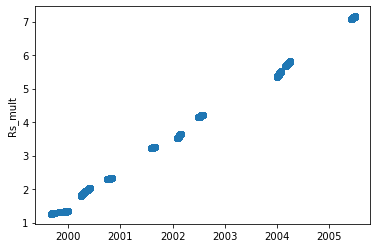

In [9]:
plt.scatter(specs_df.index, specs_df['Rs_mult'])
plt.ylabel('Rs_mult')

In [31]:


_structure_Simulator_inputs(specs_df, 'identifier')


 {'identifier': '1999-11-04 02:00:00',
  'E': 0,
  'Tc': 3.5,
  'Rs_mult': 1.3175610624322072},
 {'identifier': '1999-11-04 03:00:00',
  'E': 0,
  'Tc': 4.0,
  'Rs_mult': 1.3176757099339182},
 {'identifier': '1999-11-04 04:00:00',
  'E': 0,
  'Tc': 3.0,
  'Rs_mult': 1.3177903574356293},
 {'identifier': '1999-11-04 05:00:00',
  'E': 0,
  'Tc': 3.0,
  'Rs_mult': 1.3179050049373406},
 {'identifier': '1999-11-04 06:00:00',
  'E': 0,
  'Tc': 3.0,
  'Rs_mult': 1.3180196524390517},
 {'identifier': '1999-11-04 07:00:00',
  'E': 0,
  'Tc': 3.0,
  'Rs_mult': 1.3181342999407628},
 {'identifier': '1999-11-04 08:00:00',
  'E': 33,
  'Tc': 2.0,
  'Rs_mult': 1.318248947442474},
 {'identifier': '1999-11-04 09:00:00',
  'E': 141,
  'Tc': 3.0,
  'Rs_mult': 1.3183635949441852},
 {'identifier': '1999-11-04 10:00:00',
  'E': 60,
  'Tc': 3.0,
  'Rs_mult': 1.3184782424458963},
 {'identifier': '1999-11-04 11:00:00',
  'E': 239,
  'Tc': 2.0,
  'Rs_mult': 1.3185928899476074},
 {'identifier': '1999-11-04 12:00: